# Import Libraries

<b>What are libraries?</b>

A (software) library is a collection of files (called modules) that contains functions for use by other programs.
- May also contain data values (e.g., numerical constants) and other things.
- Library’s contents are supposed to be related, but there’s no way to enforce that.
- The Python standard library is an extensive suite of modules that comes with Python itself.
- Many additional libraries are available from PyPI (the Python Package Index).


<b>Why use libraries?</b>
- To extend the capabilities of Python
- Use software that other people have written

# Libraries used for Agent Based Modeling

In [1]:
import time, enum, math
from random import choice, sample
import numpy as np
import pandas as pd
import pylab as plt
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import NetworkGrid
from mesa.datacollection import DataCollector

import networkx as nx

In [2]:
import datetime
from datetime import datetime
from dateutil.relativedelta import relativedelta
from datetime import date

# Libraries used for visualizing Agent Based Modeling

In [3]:
from bokeh.io import show, output_notebook
from bokeh.models import ColumnDataSource, GeoJSONDataSource, ColorBar, HoverTool, Legend, LinearColorMapper, ColorBar
from bokeh.plotting import figure
from bokeh.palettes import brewer
from bokeh.models.glyphs import Line
from bokeh.palettes import Category10, Viridis
output_notebook()
import panel as pn
import panel.widgets as pnw
pn.extension()

Loading BokehJS ...

# Reading the dataset used in Agent Based Modeling

The dataset used for simulating tthe pandemic is obtained from michigan.gov : https://www.michigan.gov/coronavirus/0,9753,7-406-98163_98173---,00.html <br>

The dataset from different spreadsheet is merged and explored in Michigan_COVID_Dataset.ipynb. The final dataset consist of COVID cases tracked over one year in the Alger county of Michigan. Following fields exist in the dataset
- <b>Date</b> -> Date of tracking covid case
- <b>COUNTY</b> -> County from where data is collected
- <b>Cases_Confirmed</b> -> The number of covid cases that have been confirmed for the given date
- <b>Cases_Probable</b> -> The number of covid cases that could be probable for the given date
- <b>Cases.Cumulative_Confirmed</b> -> The cumulative number of confirmed covid cases until the date
- <b>Cases.Cumulative_Probable</b> -> The cumulative number of probable covid cases until the date
- <b>Deaths_Confirmed</b> -> The number of deaths due to covid cases that have been confirmed for the given date
- <b>Deaths_Probable</b> -> The number of deaths due to covid cases that could be probable for the given date
- <b>Deaths.Cumulative_Confirmed</b> -> The cumulative number of confirmed deaths due to covid cases until the date
- <b>Deaths.Cumulative_Probable</b> -> The cumulative number of probable deaths due to covid cases until the date
- <b>MessageDate</b> -> Date of covid testing in county labs
- <b>Negative</b> -> Number of negative covid testing outcome in county labs
- <b>Positive</b> -> Number of positive covid testing outcome in county labs
- <b>Total</b> -> Total number of covid testing outcomes in county labs
- <b>Population</b> -> Total population of the county

Use pandas library to read the file into a dataframe. Reference: https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html

In [4]:
data = pd.read_csv("//Users//kritikaversha//Desktop//Agent_Based_Modeling_MESA//covid_final.csv")

# Agent Based Modeling (S-I-R)

The SIR model is one of the simplest compartmental models, and many models are derivatives of this basic form. The model consists of three compartments:- <br>

<b>S</b>-> The number of <u>susceptible</u> individuals. When a susceptible and an infectious individual come into "infectious contact", the susceptible individual contracts the disease and transitions to the infectious compartment.<br>
<b>I</b>-> The number of <u>infectious</u> individuals. These are individuals who have been infected and are capable of infecting susceptible individuals.<br>
<b>R</b>-> for the number of <u>removed (and immune) or deceased individuals</u>. These are individuals who have been infected and have either recovered from the disease and entered the removed compartment, or died. It is assumed that the number of deaths is negligible with respect to the total population. This compartment may also be called "recovered" or "resistant".<br>

Interesting Watch: https://www.youtube.com/watch?v=gxAaO2rsdIs&ab_channel=3Blue1Brown

# Mesa

Mesa is a modular framework for building, analyzing and visualizing agent-based models.

Agent-based models are computer simulations involving multiple entities (the agents) acting and interacting with one another based on their programmed behavior. Agents can be used to represent living cells, animals, individual humans, even entire organizations or abstract entities. Sometimes, we may have an understanding of how the individual components of a system behave, and want to see what system-level behaviors and effects emerge from their interaction. Other times, we may have a good idea of how the system overall behaves, and want to figure out what individual behaviors explain it. Or we may want to see how to get agents to cooperate or compete most effectively. Or we may just want to build a cool toy with colorful little dots moving around.

Most models consist of one class to represent the model itself; one class (or more) for agents; a scheduler to handle time (what order the agents act in), and possibly a space for the agents to inhabit and move through. These are implemented in Mesa’s modeling modules:

mesa.Model, mesa.Agent

mesa.time

mesa.space

# Modeling

### Create a class and define the components of the SIR model

In [5]:
class State(enum.IntEnum):
    SUSCEPTIBLE = 0
    INFECTED = 1
    REMOVED = 2

### Create Agent class to create agents and their operations

In [6]:
class MyAgent(Agent):
    """ An agent in an epidemic model."""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        #self.gender = If gender attributes for agent exist, it can be added here
        #self.age = If age attributes for agent exist, it can be added here
        #self.county = If county attributes for agent exist, it can be added here
        self.state = State.SUSCEPTIBLE
        self.infection_time = 0

    def move(self):
        """Move the agent"""

        """Fetch in all the possible steps for a node/agent - model.grid.get_neighbors"""
        possible_steps = [
            node
            for node in self.model.grid.get_neighbors(self.pos, include_center=False)
            if self.model.grid.is_cell_empty(node)
        ]
        
        """Since agent's movements were not tracked in the dataset, we move the agent to random positions"""
        if len(possible_steps) > 0:
            new_position = self.random.choice(possible_steps)                 
            self.model.grid.move_agent(self, new_position)

    def status(self):
        """Check infection status"""
        
        if self.state == State.INFECTED:     
            drate = self.model.death_rate
            
            # Since the dataset does not track individual, we make a random choice if the infected individual recovered
            # If the individual is not alive, the state is changed to REMOVED/RECOVERED
            # Similarly, if the time difference between the individual getting infected and now is greater than recovery time, we change the state to REMOVED/RECOVERED
            alive = np.random.choice([0,1], p=[drate,1-drate])
            if alive == 0:
                self.model.schedule.remove(self)            
            t = self.model.schedule.time-self.infection_time
            if t >= self.recovery_time:          
                self.state = State.REMOVED
       

    def contact(self):
        """Find close contacts and infect"""
        
        neighbors_nodes = self.model.grid.get_neighbors(self.pos, include_center=False)
        susceptible_neighbors = [
            agent
            for agent in self.model.grid.get_cell_list_contents(neighbors_nodes)
            if agent.state is State.SUSCEPTIBLE
        ]
        for a in susceptible_neighbors:
            if self.random.random() < model.ptrans:
                a.state = State.INFECTED
                a.recovery_time = model.get_recovery_time()
                                
    def step(self):
        self.status()
        self.move()
        self.contact()
        
    def toJSON(self):        
        d = self.unique_id
        return json.dumps(d, default=lambda o: o.__dict__, 
            sort_keys=True, indent=4)


### Create Model class to create and infection model

In [7]:
class NetworkInfectionModel(Model):
    """A model for infection spread."""
    
    def __init__(self, N=10, ptrans=0.05, avg_node_degree=3,
                 progression_period=3, progression_sd=2, death_rate=0.0193, recovery_days=21,
                 recovery_sd=7):
        """Define the attributes / characteristics of your infection model"""
        self.num_nodes = N  
        prob = avg_node_degree / self.num_nodes
        
        self.initial_outbreak_size = 1
        self.recovery_days = recovery_days
        self.recovery_sd = recovery_sd
        self.ptrans = ptrans
        self.death_rate = death_rate
        
        """Create a network grid with individual in the population as nodes"""
        self.G = nx.erdos_renyi_graph(n=self.num_nodes, p=prob)
        self.grid = NetworkGrid(self.G)
        self.nodes = list(self.G.nodes())
        
        """Set the schedule activation using MESA's RandomActivation or Simultaneous Activation"""
        self.schedule = RandomActivation(self)
        self.running = True
        
        """Using the COVID dataset
        1. Create agents
        2. Set agent state attribute
        3. Schedule agents
        4. Place agent nodes in network grid"""
        count_id = 0
        for idx, rows in data.iterrows():
            self.susceptible_ag_count = rows['Cases_Probable']
            self.infected_ag_count = rows['Cases_Confirmed']
            self.removed_ag_count = rows['Deaths_Confirmed'] 
            county = rows['COUNTY']
            
            # Create susceptible agents
            if self.susceptible_ag_count > 0:
                for i in range(self.susceptible_ag_count):
                    count_id += 1
                    a = MyAgent(count_id, self)
                    self.schedule.add(a)
                    a.state = State.SUSCEPTIBLE
                    #add agent
                    node = np.random.choice(self.nodes)
                    self.grid.place_agent(a, node)
                    self.nodes.remove(node)
                    
            # Create infected agents       
            if self.infected_ag_count > 0:
                for i in range(self.infected_ag_count):
                        count_id += 1
                        a = MyAgent(count_id, self)
                        self.schedule.add(a)
                        a.state = State.INFECTED
                        a.recovery_time = self.get_recovery_time()
                        #add agent
                        node = np.random.choice(self.nodes)
                        self.grid.place_agent(a, node)
                        self.nodes.remove(node)
            
            # Create recovered/removed agents
            if self.removed_ag_count > 0:
                for i in range(self.removed_ag_count):
                        count_id += 1
                        a = MyAgent(count_id, self)
                        self.schedule.add(a)
                        a.state = State.REMOVED
                        #add agent
                        node = np.random.choice(self.nodes)
                        self.grid.place_agent(a, node) 
                        self.nodes.remove(node)
                               
        """Convert the remaining county population as susceptible nodes"""
        for node in self.nodes:
            count_id += 1
            a = MyAgent(count_id, self)
            self.schedule.add(a)
            a.state = State.SUSCEPTIBLE
            #add agent
            self.grid.place_agent(a, node)


        """Use MESA's DataCollector to collect the data generated by MESA's model"""
        self.datacollector = DataCollector(
            agent_reporters={"State": "state"})
    
    """Calculate recovery time"""
    def get_recovery_time(self):
            return int(self.random.normalvariate(self.recovery_days,self.recovery_sd))
    
    """Generate model steps and schedule."""
    def step(self):
            self.datacollector.collect(self)
            self.schedule.step()
            
    

# Analysis

In [8]:
def get_column_data(model):
    #pivot the model dataframe to get states count at each step
    agent_state = model.datacollector.get_agent_vars_dataframe()
    X = pd.pivot_table(agent_state.reset_index(),index='Step',columns='State',aggfunc=np.size,fill_value=0)    
    labels = ['Susceptible','Infected','Removed']
    X.columns = labels[:len(X.columns)]
    return X
    
def plot_states(model,ax):    
    steps = model.schedule.steps
    X = get_column_data(model)
    X.plot(ax=ax,lw=3,alpha=0.8)
    return f

In [9]:
pop= int(data.Population.unique())
#steps=(datetime.strptime(max(data['Date']), "%Y-%m-%d") - datetime.strptime(min(data['Date']), "%Y-%m-%d")).days
steps = 20
st=time.time()
print("Initiate the model")
model = NetworkInfectionModel(pop, ptrans=0.05)
for i in range(steps):
    model.step()
print (time.time()-st)
agent_state = model.datacollector.get_agent_vars_dataframe()
print (get_column_data(model)[:10])

Initiate the model
16.456254959106445
      Susceptible  Infected  Removed
Step                                
0            8853       297        1
1            7593      1543        4
2            6584      2513        8
3            5805      3230       13
4            5110      3839       20
5            4467      4377       37
6            3971      4759       68
7            3566      5018      106
8            3227      5190      170
9            2918      5314      246


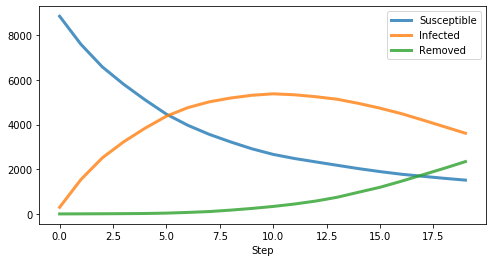

In [10]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SIR.png',dpi=150)

# Visualization using NetworkX (Not using Mesa's Visualization)

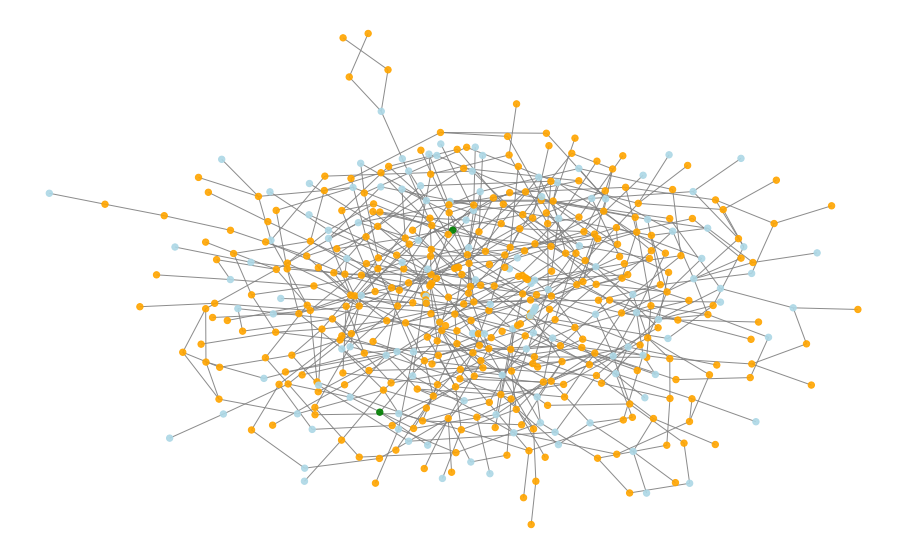

In [11]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
cmap = ListedColormap(["lightblue", "orange", "green",])

def plot_grid(model,fig,layout='spring',title=''):
    graph = model.G
    if layout == 'kamada-kawai':      
        pos = nx.kamada_kawai_layout(graph)  
    elif layout == 'circular':
        pos = nx.circular_layout(graph)
    else:
        pos = nx.spring_layout(graph, iterations=5, seed=8)  
    plt.clf()
    ax=fig.add_subplot()
    states = [int(i.state) for i in model.grid.get_all_cell_contents()]

    #cells = [(i.pos,int(i.state)) for i in model.grid.get_all_cell_contents()]
    #print (cells[:10])
    #print (pos)
    #print (pd.Series(states).value_counts())
    colors = [cmap(i) for i in states]
    
    nx.draw(graph, pos, node_size=40, edge_color='gray', node_color=colors, #with_labels=True,
            alpha=0.9,font_size=14,ax=ax)
    #print (ax.patches)
    #ax.legend(['S','I','R'])
    ax.set_title(title)
    return

fig,ax=plt.subplots(1,1,figsize=(16,10))
model = NetworkInfectionModel(476, ptrans=0.1)
#model = NetworkInfectionModel(pop, ptrans=0.1)
model.step()
f=plot_grid(model,fig,layout='kamada-kawai')
plt.savefig('abm_networkgrid.jpg')


In [12]:
def run_model(pop, ptrans, degree, steps, delay, layout):

    #model = NetworkInfectionModel(pop, ptrans=ptrans, avg_node_degree=degree)
    model = NetworkInfectionModel(476, ptrans=ptrans, avg_node_degree=degree)

    fig1 = plt.Figure(figsize=(8,6))
    grid_pane.object = fig1
    fig2 = plt.Figure(figsize=(8,6))
    ax2=fig2.add_subplot(1,1,1,label='b')
    states_pane.object = fig2 

    for i in range(steps):
        model.step()
        plot_grid(model,fig1,title='step=%s' %i, layout=layout)        
        grid_pane.param.trigger('object')
        ax2.clear()
        plot_states(model,ax2)
        ax2.set_xlim(0,steps)
        #states_pane.object = fig2
        states_pane.param.trigger('object')    
        time.sleep(delay)
    plt.clf()
    

In [13]:
grid_pane = pn.pane.Matplotlib()
states_pane = pn.pane.Matplotlib()
go_btn = pnw.Button(name='run',width=100,button_type='primary')
#pop_input = pnw.IntSlider(name='population',value=pop,start=10,end=1000,step=10,width=100)
pop_input = pnw.IntSlider(name='population',value=100,start=10,end=1000,step=10,width=100)
ptrans_input = pnw.FloatSlider(name='prob. trans',value=0.1,width=100)
degree_input = pnw.IntSlider(name='node degree',value=3,start=1,end=10,width=100)
steps_input = pnw.IntSlider(name='steps',value=20,start=5,end=100,width=100)
delay_input = pnw.FloatSlider(name='delay',value=.2,start=0,end=3,step=.2,width=100)
layout_input = pnw.Select(name='layout',options=['spring','circular','kamada-kawai'],width=100)
widgets = pn.WidgetBox(go_btn,pop_input,ptrans_input,degree_input,steps_input,delay_input,layout_input)

def execute(event):
    run_model(pop_input.value, ptrans_input.value, degree_input.value, steps_input.value, delay_input.value, layout_input.value)
go_btn.param.watch(execute, 'clicks')
    
target = pn.Row(pn.Column(widgets),grid_pane,states_pane,sizing_mode='stretch_width')
target.show()

Launching server at http://localhost:55299
